In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Replace with the path to your zip file in Google Drive
zip_file_path = '/content/drive/My Drive/GenAI/intel.zip'

# Replace with the desired directory to extract the files in Colab
extract_dir = '/content/dataset'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Unzip the file
!unzip "{zip_file_path}" -d "{extract_dir}"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7647.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7652.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7654.jpg  
  inflating: /content/dataset/seg_train/seg_train/mountain/7662.jpg  
  inflating: /content/dataset/seg_train

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings('ignore')

In [2]:
extract_dir = '/content/dataset'
data_dir = extract_dir
train_dir = os.path.join(data_dir, 'seg_train/seg_train')
test_dir = os.path.join(data_dir, 'seg_test/seg_test')

# Create lists to store filenames and labels for training data
train_filenames = []
train_labels = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        for filename in os.listdir(label_dir):
            train_filenames.append(os.path.join(label, filename))
            train_labels.append(label)

# Create a DataFrame for training data
df_train = pd.DataFrame({'filename': train_filenames, 'label': train_labels})

# Create lists to store filenames for testing data (no labels provided in test set)
test_filenames = []
test_labels = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir):
        for filename in os.listdir(label_dir):
            test_filenames.append(os.path.join(label, filename))
            test_labels.append(label)

# Create a DataFrame for testing data
df_test = pd.DataFrame({'filename': test_filenames, 'label': test_labels})

print("Training DataFrame head:")
display(df_train.head())
print("\nTesting DataFrame head:")
display(df_test.head())

Training DataFrame head:


,filename,label
0,glacier/6186.jpg,glacier
1,glacier/24.jpg,glacier
2,glacier/11035.jpg,glacier
3,glacier/9388.jpg,glacier
4,glacier/4128.jpg,glacier



Testing DataFrame head:


,filename,label
0,glacier/22556.jpg,glacier
1,glacier/22695.jpg,glacier
2,glacier/23656.jpg,glacier
3,glacier/21153.jpg,glacier
4,glacier/21464.jpg,glacier


In [3]:


encoder = LabelEncoder()
df_train['label_enc'] = encoder.fit_transform(df_train['label'])
df_test['label_enc'] = encoder.transform(df_test['label'])
num_classes = len(encoder.classes_)
encoder.classes_

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype=object)

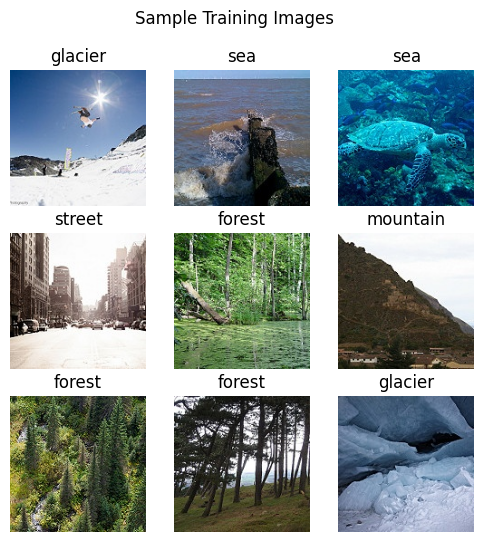

In [4]:
sample = df_train.sample(9, random_state=42)
plt.figure(figsize=(6,6))
for i, row in enumerate(sample.itertuples()):
    img_path = os.path.join(data_dir, "seg_train/seg_train", row.filename)
    img = Image.open(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(row.label)
    plt.axis("off")
plt.suptitle("Sample Training Images")
plt.show()

In [5]:
image_size = 64
def load_images(df, folder, train=True):
    images, labels = [], []
    for i in range(len(df)):
        img_path = os.path.join(folder, df.iloc[i ,0])
        img = load_img(img_path, target_size=(image_size, image_size))
        img = img_to_array(img)
        images.append(img)

        # if train:
        labels.append(df.iloc[i]['label_enc'])
    return np.array(images), to_categorical(labels, num_classes=num_classes)
    # if train:
    #     return np.array(images), to_categorical(labels, num_classes=num_classes)
    # else:
    #     return np.array(images)

In [6]:
X_train, y_train = load_images(df_train, os.path.join(data_dir, "seg_train/seg_train"), train=True)
X_test, y_test = load_images(df_test, os.path.join(data_dir, "seg_test/seg_test"), train=False)

In [7]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [8]:
from sklearn.model_selection import train_test_split
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

train_gen = datagen.flow(X_train2, y_train2, batch_size=64, shuffle=True)
val_gen   = datagen.flow(X_val, y_val, batch_size=64, shuffle=False)


## Build model

### Subtask:
Build a convolutional neural network (CNN) model for image classification.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Clear any previous models to avoid conflicts
import tensorflow.keras.backend as K
K.clear_session()

model = Sequential([
    # First Conv Block with BatchNorm
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3), padding='same',
           kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(2,2),
    Dropout(0.2),

    # Second Conv Block
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(2,2),
    Dropout(0.2),

    # Third Conv Block
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax', kernel_initializer='glorot_normal')
])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,656,998 (82.61 MB)

 Trainable params: 21,655,526 (82.61 MB)

 Non-trainable params: 1,472 (5.75 KB)

## Compile and train model

### Subtask:
Compile the model with an appropriate optimizer and loss function, then train it on the preprocessed data.


**Reasoning**:
Compile and train the model using the specified optimizer, loss function, metrics, and data.



In [10]:
# 1. Compile the model.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    verbose=1
)

Epoch 1/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 95ms/step - accuracy: 0.4737 - loss: 3.2685 - val_accuracy: 0.2034 - val_loss: 4.3628
Epoch 2/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6729 - loss: 2.2108 - val_accuracy: 0.3705 - val_loss: 2.8787
Epoch 3/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7508 - loss: 1.7191 - val_accuracy: 0.6958 - val_loss: 1.7844
Epoch 4/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7724 - loss: 1.4295 - val_accuracy: 0.6854 - val_loss: 1.7331
Epoch 5/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8126 - loss: 1.1711 - val_accuracy: 0.6840 - val_loss: 1.4797
Epoch 6/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8159 - loss: 1.0343 - val_accuracy: 0.7467 - val_loss: 1.1659
Epoch 7/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8373 - loss: 0.9050 - val_accuracy: 0.8169 - val_loss: 0.9290
Epoch 8/25
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8478 - loss: 0.8226 - val_acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


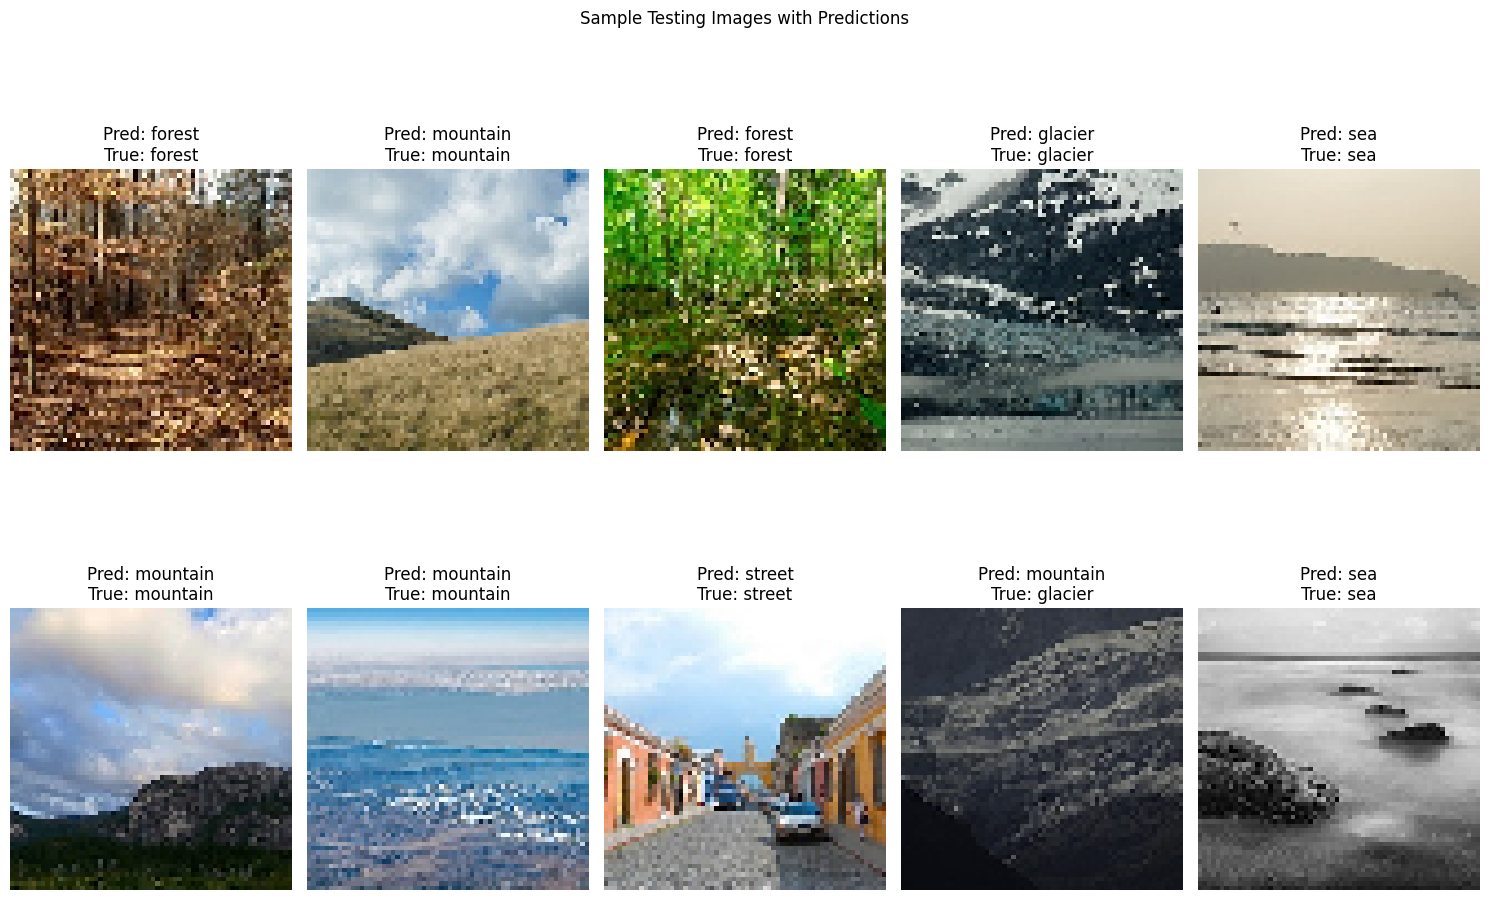

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Use a sample from the training set to display predictions with true labels
sample_test = df_test.sample(10, random_state=42)

# Load the actual images for the sampled training data
sample_images = []
true_labels_class_names = []
for index, row in sample_test.iterrows():
    img_path = os.path.join("/content/dataset", "seg_test/seg_test", row['filename'])
    img = load_img(img_path, target_size=(image_size, image_size))
    img = img_to_array(img) / (255.0)
    sample_images.append(img)
    true_labels_class_names.append(row['label'])

sample_images = np.array(sample_images)
new_images = sample_images

# 1. Make predictions on the sampled training images.
predictions = model.predict(sample_images)


# 2. Display the images and their predicted labels.
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Display the image
    plt.imshow(new_images[i])

    # Get the predicted class index and convert to class name
    predicted_class_index = np.argmax(predictions[i])
    predicted_class_name = encoder.inverse_transform([predicted_class_index])[0]

    # Get the true class name
    true_class_name = true_labels_class_names[i]


    plt.title(f"Pred: {predicted_class_name}\nTrue: {true_class_name}")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Sample Testing Images with Predictions", y=1.02)
plt.show()

In [13]:
test_gen = ImageDataGenerator(rescale=1./255).flow(X_test, y_test, batch_size=64, shuffle=False)
loss, acc = model.evaluate(test_gen)
print("Test accuracy:", acc)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8514 - loss: 0.7933
Test accuracy: 0.8306666612625122
